In [1]:
from ilqr.envs import PointMass, Arm
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib
import ipdb
import io

%matplotlib inline
%load_ext autoreload
%autoreload 2

# utility function

# show videos in ipython given frames
# modified from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb#scrollTo=gKc1FNhKiVJX
def display_video(frames, framerate=30):
    dpi=70
    height, width = frames[0].shape[:2]
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width/dpi, height/dpi), dpi=dpi);

    matplotlib.use(orig_backend)  # switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])

    im = ax.imshow(frames[0], aspect='auto');
    def update(frame):
      im.set_data(frame)
      return [im]

    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [24]:
def iLQR(env, iterations=100, 
         reg = 1,                  # initial regularization
         reg_lims = (1e-6, 1e10),  # limtis on regularization
         dreg = 2,                 # reg is multiplied or divided by dreg
         dreg_factor = 1.6,        # dreg is multiplied or diveded by dreg_factor):
         alpha = 1,
         verbose = False,
        ):        

    """
    todo:
    - line search for alpha parameter
    - add convergence check
    
    fixes:
    - moidfy matrix inversion
    - simpler V updates
    - divergence check
    - add control cost
    - add alpha
    - add reg to V_xx, not Q_xx
    """

    # initial trajectory
    actions = [(0,0) for i in range(env.max_steps)]
    states, costs, costs_derivs = env.rollout(actions)
    state_derivs = [env.state_derivs(s,a) for s,a in zip(states, actions)]
    V_x  = costs_derivs[-1]['l_x']
    V_xx = costs_derivs[-1]['l_xx']
    history = dict(cost=[sum(costs)], reg=[reg])

    for i in tqdm(range(iterations)) if not verbose else range(iterations):
        k, K = [], []
        diverged = False

        # backward pass
        # (compute new control rules k and K)
        for t in range(env.max_steps-1, -1, -1):
            l, f = costs_derivs[t], state_derivs[t]

            Q_x  = l['l_x']  + f['f_x'].T @ V_x
            Q_u  = l['l_u']  + f['f_u'].T @ V_x
            Q_xx = l['l_xx'] + f['f_x'].T @ V_xx @ f['f_x']
            Q_uu = l['l_uu'] + f['f_u'].T @ V_xx @ f['f_u']
            Q_ux = l['l_ux'] + f['f_u'].T @ V_xx @ f['f_x']

            # compute Q_uu inverse
            Q_uu += np.diag([reg]*len(Q_u))
            diverged = np.any(np.linalg.eigvals(Q_uu) <= 0)  # check if positive definite
            
            if diverged:
                # increase regularization
                dreg = max(dreg_factor, dreg_factor*dreg)
                reg = min(max(reg*dreg, reg_lims[0]), reg_lims[1])
                print('({}) divereged at time {}'.format(i, t))
                break
            
            # eigs
#             evals, evecs = np.linalg.eig(Q_uu)
#             evals += reg
#             divered = any(evals<0)
#             Q_uu_inv = evecs @ np.diag(1/evals) @ evecs.T
            
            # pinv
#             Q_uu += np.diag([reg]*len(Q_u))
#             Q_uu_inv = np.linalg.pinv(Q_uu)
            
            # inv
#             Q_uu_inv = np.linalg.pinv(Q_uu)
            
            # cholesky
            c = np.linalg.inv(np.linalg.cholesky(Q_uu))
            Q_uu_inv = c.T @ c
            
            # control law
            k.append(-Q_uu_inv @ Q_u)
            K.append(-Q_uu_inv @ Q_ux)

            # update V
            V_x  = Q_x  + K[-1].T @ Q_uu @ k[-1] + K[-1].T @ Q_u  + Q_ux.T @ k[-1]
            V_xx = Q_xx + K[-1].T @ Q_uu @ K[-1] + K[-1].T @ Q_ux + Q_ux.T @ K[-1]
#             V_x  = Q_x  - Q_u    @ Q_uu_inv @ Q_ux
#             V_xx = Q_xx - Q_ux.T @ Q_uu_inv @ Q_ux
            
            # check for bad things
            for x in [Q_x, Q_u, Q_xx, Q_uu, Q_ux, Q_uu_inv, V_x, V_xx]:
                if np.any(np.isnan(x)) or np.any(np.isinf(x)):
                    ipdb.set_trace()
            
        if not diverged:
            k.reverse()
            K.reverse()

            # forward pass
            # (compute new trajectory with new control law)
            states_new, costs_new, actions_new = [], [], []
            states_new.append(env.reset(reset_target=False))

            for t in range(env.max_steps):
                action_new = actions[t] + alpha*k[t] + K[t] @ (states_new[-1] - states[t])
                actions_new.append(action_new)
                costs_new.append(env.cost(states_new[-1], actions_new[-1])[0])
                states_new.append(env.step(actions_new[-1]))
            history['cost'].append(sum(costs_new))

            # regularization update
            delta_cost = sum(costs_new) - sum(costs)

            # increase regularization
            if delta_cost>0:
                if verbose: print(f'({i}) cost increased by {delta_cost} with reg {reg}...')
                dreg = max(dreg_factor, dreg_factor*dreg)
                reg = min(max(reg*dreg, reg_lims[0]), reg_lims[1])

            # decrease regularization
            else:
                if verbose: print(f'({i}) cost decreased by {delta_cost} with reg {reg}...')
                dreg = min(1/dreg_factor, dreg/dreg_factor)
                reg *= dreg * (reg > reg_lims[0])  # latter term sets reg=0 if reg<=reg_lims[0]

                actions = actions_new.copy()
                states = states_new.copy()
                costs = costs_new.copy()
            history['reg'].append(reg)
    
    return actions, history

# two link arm

(0) divereged at time 228
(1) divereged at time 249
(2) divereged at time 249
(3) divereged at time 249
(4) divereged at time 249
(5) divereged at time 249
(6) divereged at time 249
(7) divereged at time 249
(8) divereged at time 61
(9) cost increased by 3.910732403869826 with reg 784637716923.3374...
(10) cost increased by 3.910732384158287 with reg 172543658669764.7...
(11) cost increased by 3.910732384030112 with reg 6.070840288205428e+16...
(12) cost increased by 3.910732384029618 with reg 3.417579257473472e+19...
(13) cost increased by 3.9107323840296146 with reg 3.078281734093335e+22...
(14) cost increased by 3.9107323840296146 with reg 4.436271510593331e+25...
(15) cost increased by 3.9107323840296146 with reg 1.0229345649675515e+29...
(16) cost increased by 3.9107323840296146 with reg 3.7739624248215716e+32...
(17) cost increased by 3.9107323840296146 with reg 2.2277542078233577e+36...
(18) cost increased by 3.9107323840296146 with reg 2.1040543606193706e+40...
(19) cost increa

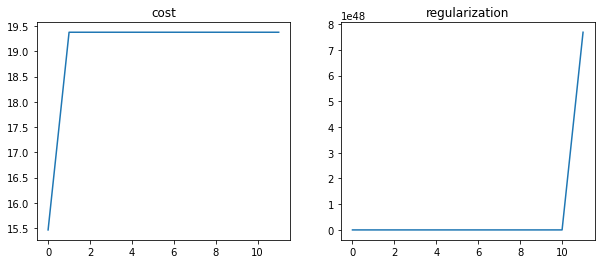

In [26]:
# run ilqr
env = Arm(control_wgt=1)
actions, history = iLQR(env, iterations=20, reg=1, alpha=1, verbose=True, reg_lims=(1e-6, 1e100))

ax = plt.subplots(1,2, figsize=(10,4))[1];
ax[0].plot(history['cost']); ax[0].set_title('cost');
ax[1].plot(history['reg']);  ax[1].set_title('regularization');

In [21]:
# show video
env.reset(reset_target=False)
imgs= [env.render()]
for action in actions:
    env.step(action)
    imgs.append(env.render())
#     print(action, env.env.physics.finger_to_target_dist(), env.env.physics.time())
display_video(imgs, framerate=(1/env.dt))



# point mass

In [305]:
state_derivs[-1]['f_x'].round(2)

array([[1.  , 0.  , 0.02, 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.83, 0.2 ],
       [0.  , 0.  , 0.2 , 0.24]])

In [ ]:
# run ilqr
env = PointMass()
actions, history = iLQR(env, iterations=100, reg=1e-2)
ax = plt.subplots(1,2, figsize=(10,4))[1];
ax[0].plot(history['cost']); ax[0].set_title('cost');
ax[1].plot(history['reg']);  ax[1].set_title('regularization');

In [ ]:
# show video
env.reset(reset_target=False)
imgs= []
for action in actions:
    env.step(action)
    imgs.append(env.render())
display_video(imgs, framerate=(1/env.dt))